In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tabulate import tabulate
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PowerTransformer
# from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [2]:
INPUT_DIR = '/kaggle/input/rohlik-sales-forecasting-challenge-v2'
OUTPUT_DIR = '/kaggle/working'

## 1. Data Ingestion

In [3]:
df_sales = pd.read_csv(os.path.join(INPUT_DIR, "sales_train.csv"))
df_cal = pd.read_csv(os.path.join(INPUT_DIR, "calendar.csv"))
df_inv = pd.read_csv(os.path.join(INPUT_DIR, "inventory.csv"))
df_test = pd.read_csv(os.path.join(INPUT_DIR, "sales_test.csv"))

df_cal_enriched_2025 = pd.read_csv('/kaggle/input/extended-calendar-dataset-for-rohlik-challenge/calendar_enriched_2025-01-05.csv')

## 2. Data Preparation

In [4]:
#converting datatype
df_sales["date"] = pd.to_datetime(df_sales["date"])
df_test["date"] = pd.to_datetime(df_test["date"])
df_cal_enriched_2025["date"] = pd.to_datetime(df_cal_enriched_2025["date"])

In [5]:
# Handle Null Values
df_sales = df_sales.dropna()
df_cal_enriched_2025["date_holiday_name"] = df_cal_enriched_2025["date_holiday_name"].replace({np.NaN: "Unnamed"})

# drop columns
df_sales = df_sales.drop(columns=["availability"])

### 2.1 Adding Date and Lag Features

In [6]:
# Feature generation functions
def add_date_features(df):
    df['date_year'] = df['date'].dt.year
    df['date_month'] = df['date'].dt.month
    df['date_day'] = df['date'].dt.day
    df['date_weekofyear'] = df['date'].dt.isocalendar().week
    df['date_weekday'] = df['date'].dt.weekday 
    df['date_dayofyear'] = df['date'].dt.dayofyear
    df['date_year_sin'] = np.sin((df['date_year'] - df['date_year'].min()) / (df['date_year'].max() - df['date_year'].min()) * 2 * np.pi)
    df['date_year_sin'] = np.sin(df['date_year'] / 1 * 2 * np.pi)
    df['date_month_sin'] = np.sin(df['date_month'] / 12 * 2 * np.pi)
    return df

periods = [14, 21, 28, 56, 112, 224, 365]
def add_lag_sales(df_sales):
    for period in periods:
        df_sales[f"sales_lag_{period}"] = df_sales.groupby("unique_id")["sales"].shift(period)
        df[f"sales_lag_{period}"] = df[f"sales_lag_{period}"].fillna(0)
    
    return df_sales

In [7]:
df_test["sales"] = 0
df = pd.concat([df_sales, df_test], ignore_index=True).sort_values("date")
df = df.merge(df_cal_enriched_2025, on=['date', 'warehouse'], how='left')
df = df.merge(df_inv, on=['unique_id', 'warehouse'], how='left')

df = add_date_features(df)
df = add_lag_sales(df)

# replacing NaN with 0 but I think it would be better to replace it with current value of sale
del df_sales, df_test, df_inv, df_cal, df_cal_enriched_2025

### 2.2 Statistical Feature Engineering

In [8]:
# average sale of product in previous year
grouped = df.groupby(["unique_id", "date_year"], as_index=False)["sales"].mean()
grouped["prev_year_avg_sale"] = grouped.groupby(["unique_id"], as_index=False)["sales"].shift(1)
grouped = grouped.drop(columns=["sales"]).fillna(0)

df = df.merge(grouped, on=["unique_id", "date_year"])

In [9]:
#average sale of the product at the same month in previous year
grouped = df.groupby(["unique_id", "date_year", "date_month"], as_index=False)["sales"].mean()
grouped["prev_year_month_avg_sale"] = grouped.groupby(["unique_id"])["sales"].shift(12)
grouped = grouped.drop(columns=["sales"]).fillna(0)

df = df.merge(grouped, on=["unique_id", "date_year", "date_month"])

In [10]:
#average sale of the product at the quarter in previous year
df["date_quarter"] = df["date_month"] // 4
grouped = df.groupby(["unique_id", "date_year", "date_quarter"], as_index=False)["sales"].mean()
grouped["prev_year_quarter_avg_sale"] = grouped.groupby(["unique_id"])["sales"].shift(12)
grouped = grouped.drop(columns=["sales"]).fillna(0)

df = df.merge(grouped, on=["unique_id", "date_year", "date_quarter"])

In [11]:
#sale of the product at the same date in previous years
df["prev_year_date_sale"] = df.groupby(["unique_id"], as_index=False)["sales"].shift(365).fillna(0)

In [12]:
# std of sale of the product in previous years
grouped = df.groupby(["unique_id", "date_year"], as_index=False)["sales"].std()
grouped["prev_year_std_sale"] = grouped.groupby(["unique_id"], as_index=False)["sales"].shift(1)
grouped = grouped.drop(columns=["sales"]).fillna(0)

df = df.merge(grouped, on=["unique_id", "date_year"])

In [13]:
# std of the product at the same month in previous year
grouped = df.groupby(["unique_id", "date_year", "date_month"], as_index=False)["sales"].std()
grouped["prev_year_month_std_sale"] = grouped.groupby(["unique_id"])["sales"].shift(12)
grouped = grouped.drop(columns=["sales"]).fillna(0)

df = df.merge(grouped, on=["unique_id", "date_year", "date_month"])

In [14]:
# average sale of the product in the time period from January to June (because data after june
# is not available for test set)

grouped = df[df["date_month"].between(1, 6)].groupby(["unique_id"], as_index=False)["sales"].mean().rename(columns={"sales": "avg_sale_upto_june"})
df = df.merge(grouped, on=["unique_id"])

In [15]:
# what's the maximum and minimum price of a particular product(for the year) 
# (because if a product's maximum price is greater than the current price then it's sale perhaps would be higher)

grouped = df.groupby(["unique_id", "date_year"], as_index=False)["sell_price_main"].min().rename(columns={"sell_price_main": "min_price"})
df = df.merge(grouped, on=["unique_id", "date_year"])

grouped = df.groupby(["unique_id", "date_year"], as_index=False)["sell_price_main"].max().rename(columns={"sell_price_main": "max_price"})
df = df.merge(grouped, on=["unique_id", "date_year"])

### 2.3 Feature Transformations

In [16]:
# log transformation
cols = ['total_orders', 'sell_price_main',
       'type_0_discount', 'type_1_discount', 'type_2_discount',
       'type_3_discount', 'type_4_discount', 'type_5_discount',
       'type_6_discount', 'date_holiday_flag', 'date_shops_closed_flag',
       'date_winter_school_holidays_flag', 'date_school_holidays_flag',
       'date_days_to_next_holiday', 'date_days_to_shops_closed',
       'date_day_after_closed_day', 'date_second_closed_day',
       'date_day_after_two_closed_days', 'product_unique_id', 'date_year_sin',
       'date_month_sin', 'sales_lag_14', 'sales_lag_21', 'sales_lag_28',
       'sales_lag_56', 'sales_lag_112', 'sales_lag_224', 'sales_lag_365',
       'prev_year_avg_sale', 'prev_year_date_sale',
       'prev_year_std_sale', 'prev_year_month_std_sale', "prev_year_quarter_avg_sale"]

In [17]:
def apply_transformations(df, cols):
    pt = PowerTransformer(method="box-cox")
    print("Transformation being applied on...")
    for col in cols:
        print(f"\t{col}")
        
        if(df[col].min() >= 0):
            df[f"{col}_sqrt"] = np.sqrt(df[col])
            
        if(df[col].min() > 0):
            df[f"{col}_log"] = np.log(df[col])
            df[f"{col}_box_cox"] = pt.fit_transform(df[[col]]).flatten()

    return df

In [18]:
df = apply_transformations(df, cols)

Transformation being applied on...
	total_orders
	sell_price_main
	type_0_discount
	type_1_discount
	type_2_discount
	type_3_discount
	type_4_discount
	type_5_discount
	type_6_discount
	date_holiday_flag
	date_shops_closed_flag
	date_winter_school_holidays_flag
	date_school_holidays_flag
	date_days_to_next_holiday
	date_days_to_shops_closed
	date_day_after_closed_day
	date_second_closed_day
	date_day_after_two_closed_days
	product_unique_id
	date_year_sin
	date_month_sin
	sales_lag_14
	sales_lag_21
	sales_lag_28
	sales_lag_56
	sales_lag_112
	sales_lag_224
	sales_lag_365
	prev_year_avg_sale
	prev_year_date_sale
	prev_year_std_sale
	prev_year_month_std_sale
	prev_year_quarter_avg_sale


In [19]:
# Target feature transformation
df['sales'] = df['sales']**(1/8)

### 2.4 Warehouse feature engineering

In [20]:
# average sale of the warehouse during that year
grouped = df.groupby(["warehouse", "date_year"], as_index=False)['sales'].mean().rename(columns={"sales": "avg_warehouse_sales_per_year"})
df = df.merge(grouped, on=["warehouse", "date_year"])

### 2.3 Rolling average of sales

In [21]:
# size = 30
# unique_id=1285
# df_roll = df.copy()
# df_roll[f"sales_roll_{size}"] = df.groupby("unique_id", as_index=False)["sales"].rolling(window=size).mean().fillna(0)["sales"]

# df_roll = df_roll[df_roll['unique_id']==unique_id]
# plt.figure(figsize=(10, 5))
# plt.plot(df_roll["date"], df_roll["sales"], color="lightblue", label="sales")
# plt.plot(df_roll["date"], df_roll[f"sales_roll_{size}"], color="red", label=f"rolling_sales_{size}")
# plt.legend()
# plt.xlabel("date")
# plt.ylabel("sales")

# del df_roll

In [22]:
# window_sizes = [7, 15, 30, 60, 90, 120, 270, 365]
# def add_rolling_features(df):
#     for size in window_sizes:
#         df[f"sales_rolled_{size}"] = df.groupby("unique_id", as_index=False)["sales"].rolling(window=size).mean()["sales"]
#         df[f"sales_rolled_{size}"] = df[f"sales_rolled_{size}"].fillna(0)
#     return df

In [23]:
# df = add_rolling_features(df)
# The score dropped to 57 from 21 when rolling features were used

## 3. Training and Test Prediction

In [24]:
# Ensuring correct datatypes

for col in df.select_dtypes("object").columns:
    df[col] = df[col].astype('category')

### 3.1 Simple XGBoost

In [25]:
# Train Test split 
train_dates = ("2020-08-01", "2024-06-02")
# val_dates = ("2024-05-19", "2024-06-02")
test_dates = ("2024-06-03", "2024-06-17")

X_train = df[df["date"].between(train_dates[0], train_dates[1])].drop(columns= ["sales"])
y_train = df[df["date"].between(train_dates[0], train_dates[1])]["sales"]
# X_val = df[df["date"].between(val_dates[0], val_dates[1])].drop(columns= ["sales"])
# y_val = df[df["date"].between(val_dates[0], val_dates[1])]["sales"]
X_test = df[df["date"].between(test_dates[0], test_dates[1])].drop(columns=["sales"])
y_test = df[df["date"].between(test_dates[0], test_dates[1])]["sales"]

* eta = 0.02 led to score 18.09 in 1500 iterations
* eta=0.06 led to 17.84 in 1500 iterations. 

In [26]:
params = {
    "objective": "reg:absoluteerror",
    "eta": 0.08,
    "max_depth": 12,
    "random_state": 42,
    "gamma": 0.1,
    "subsample": 0.6,
    "device": 'cuda',
}
num_boost_round = 400

dmat = xgb.DMatrix(X_train.drop(columns=["date"]), y_train, enable_categorical=True)
# dmat_val = xgb.DMatrix(X_val.drop(columns=["date"]), y_val, enable_categorical=True)
# xgb_reg = xgb.train(params, dmat, num_boost_round=num_boost_round,  evals=[(dmat_val, 'val_set'), (dmat, 'train_set')], early_stopping_rounds=10)
xgb_reg = xgb.train(params, dmat, num_boost_round=num_boost_round,  evals=[(dmat, 'train_set')], early_stopping_rounds=10)

[0]	train_set-mae:0.20514
[1]	train_set-mae:0.19298
[2]	train_set-mae:0.18205
[3]	train_set-mae:0.17193
[4]	train_set-mae:0.16274
[5]	train_set-mae:0.15430
[6]	train_set-mae:0.14654
[7]	train_set-mae:0.13954
[8]	train_set-mae:0.13328
[9]	train_set-mae:0.12748
[10]	train_set-mae:0.12219
[11]	train_set-mae:0.11739
[12]	train_set-mae:0.11306
[13]	train_set-mae:0.10863
[14]	train_set-mae:0.10493
[15]	train_set-mae:0.10156
[16]	train_set-mae:0.09843
[17]	train_set-mae:0.09560
[18]	train_set-mae:0.09307
[19]	train_set-mae:0.09072
[20]	train_set-mae:0.08860
[21]	train_set-mae:0.08670
[22]	train_set-mae:0.08498
[23]	train_set-mae:0.08343
[24]	train_set-mae:0.08201
[25]	train_set-mae:0.08072
[26]	train_set-mae:0.07958
[27]	train_set-mae:0.07849
[28]	train_set-mae:0.07750
[29]	train_set-mae:0.07651
[30]	train_set-mae:0.07564
[31]	train_set-mae:0.07486
[32]	train_set-mae:0.07410
[33]	train_set-mae:0.07338
[34]	train_set-mae:0.07274
[35]	train_set-mae:0.07217
[36]	train_set-mae:0.07160
[37]	train_

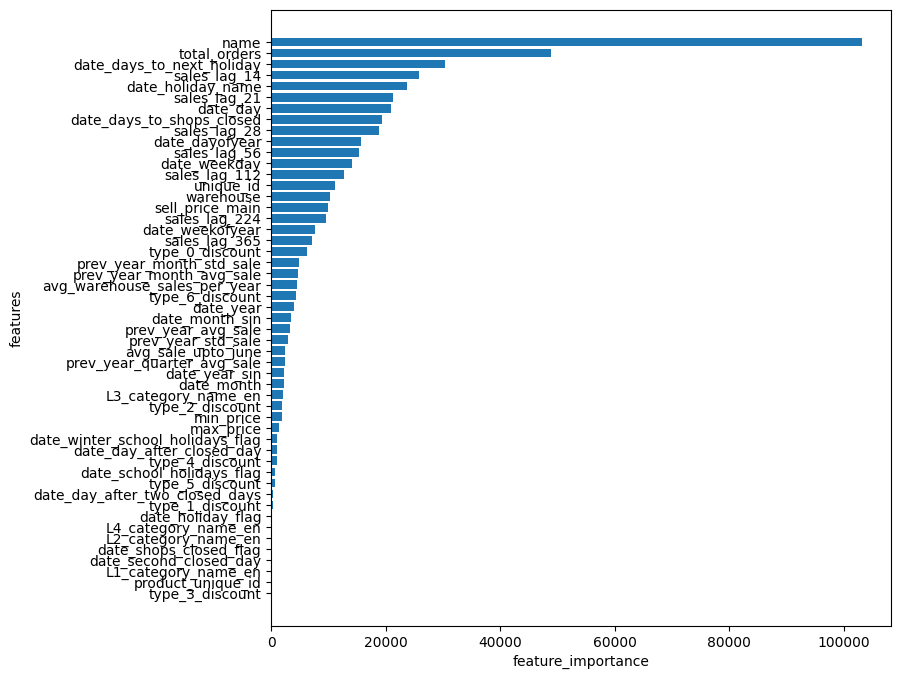

In [27]:
def plot_feature_importance_xgboost(xgb_model):
    feat_imp = np.array(list(xgb_model.get_score(importance_type='weight').values()))
    feat_names = np.array(list(xgb_model.get_score(importance_type='weight').keys()))
    sorted_indices = np.argsort(feat_imp)
    feat_names = feat_names[sorted_indices]
    feat_imp = feat_imp[sorted_indices]
    
    plt.figure(figsize=(8, 8))
    plt.barh(feat_names, feat_imp)
    plt.xlabel("feature_importance")
    plt.ylabel("features")

plot_feature_importance_xgboost(xgb_reg)

In [28]:
dmat = xgb.DMatrix(X_test.drop(columns=["date"]), enable_categorical=True)
test_pred = xgb_reg.predict(dmat)

#undoing target transformation
test_pred = test_pred**8

# prediction processing
unique_id = X_test["unique_id"].astype('string')
date = X_test["date"].astype('string')
test_id = unique_id + "_" +  date

df_sub = pd.DataFrame({
    "id": test_id,
    "sales_hat": test_pred.astype("int64")
})

df_sub.to_csv("submission.csv", index=False)